In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(12345)

In [2]:
# generate data 
n = 21
f = lambda x: .7*np.sin(5 * x) * (1 - np.tanh(x ** 2))

# precision of prior
alpha = 1.

# precision of noise
s = .2
beta = 1./s**2

x = np.linspace(-1., 1., n)
t = f(x) + s * np.random.randn(n) 

In [3]:
# analytical posterior 
basis = lambda x: jnp.array([1., x, x**2, x**3, x**4, x**5])
Phi = vmap(basis)(x)

# Hessian 
Sinv = alpha*np.eye(Phi.shape[1]) + beta * Phi.T @ Phi 
# Covariance
S = np.linalg.inv(Sinv)
# Mean 
m = beta * S @ Phi.T @ t

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
# posterior predictive distribution 
x_eval = np.linspace(-1.2, 1.2, 100)
Phi = vmap(basis)(x_eval)
t_hat = Phi@m
s_hat = np.sqrt(np.einsum('ni,ij,nj->n', Phi, S, Phi))

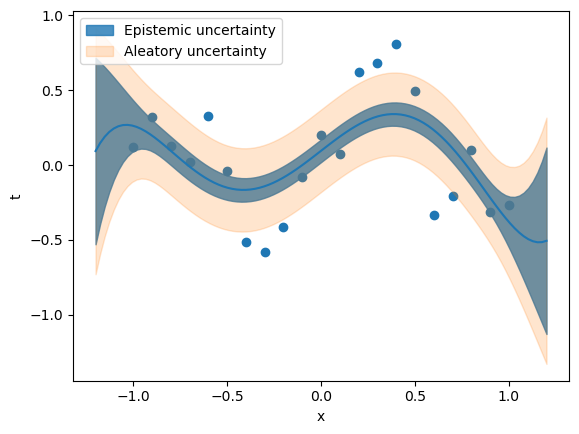

In [5]:
plt.scatter(x, t)
plt.plot(x_eval, t_hat)
plt.fill_between(x_eval, t_hat-s_hat, t_hat+s_hat, alpha=.8, color='C0', 
                 label='Epistemic uncertainty')
plt.fill_between(x_eval, t_hat-(s+s_hat), t_hat+s+s_hat, alpha=.2, color='C1', 
                 label='Aleatory uncertainty')
plt.legend()
plt.xlabel("x")
plt.ylabel("t")
plt.show()

In [6]:
# define model that takes in unknown parameters (latent variables)
@jit
def model(x, z):
    
    a, b, c, d, e, f = z
    
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

# gradient of model w.r.t. parameters
grad_model = jit(jacfwd(model, 1))

# problem dimension
d = 6

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[d], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.random.randn(n_params) / 2.

# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    mu, log_s = reshape(lmbda)
    
    # convert to z 
    z = mu + jnp.exp2(log_s)*y
    
    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))

@jit 
def inv_nn(z, lmbda):
    
    # weights and biases of nn
    mu, log_s = reshape(lmbda)

    # invert to standard Gaussian
    y = (z - mu) / jnp.exp2(log_s)

    return y 
    
# gradient of nn output w.r.t. parameters
jac_nn = jit(jacfwd(nn, 0))
jac_inv_nn = jit(jacfwd(inv_nn, 0))

@jit
def log_abs_det(lmbda):
    mu, log_s = reshape(lmbda)
    # return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))
    return jnp.sum(jnp.log(jnp.exp2(log_s)))

# gradient of entropy of approximating distribution w.r.t. lmbda
grad_log_abs_det = jit(jacfwd(log_abs_det))

In [7]:
# ELBO cost function 
def elbo(lmbda, n_sample=1000):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # init elbo with entropy of VI posterior
    ELBO = -log_abs_det(lmbda)
    
    # evaluate model fitness 
    for yi, zi in zip(y, z):
        # likelihood
        ELBO += beta * np.sum((t - model(x, zi))**2) / 2. / n_sample
        # prior
        ELBO += alpha * np.sum(zi**2) / 2. / n_sample
    
    return ELBO

# gradient of ELBO cost function
def grad_elbo(lmbda, n_sample=1000):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # gradient of entropy
    grad_ELBO = -grad_log_abs_det(lmbda)
    
    # gradient 
    grad_nn_eval = grad_nn(y, lmbda)
    for gi, yi, zi in zip(grad_nn_eval, y, z):
        # likelihood
        grad_ELBO += beta * np.einsum('t,ti,ij->j', model(x, zi) - t, grad_model(x, zi), gi) / n_sample
        # prior 
        grad_ELBO += alpha * np.einsum('i,ij->j', zi, gi) / n_sample
    
    return grad_ELBO

In [8]:
# make sure NN is flexible enough to capture true posterior

# nll of true posterior
@jit 
def neg_log_likelihood(yi, lmbda):
    zi = nn(yi, lmbda)
    return jnp.einsum('i,ij,j', m-zi, Sinv, m-zi) / 2.
grad_neg_log_likelihood = jit(jacfwd(neg_log_likelihood, 1))

# kl divergence btw q(lmbda) and p(z | X)
def kl(lmbda, n_sample=1000):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    KL = -log_abs_det(lmbda)
    for yi, zi in zip(y, z):
        # divergence btw true posterior
        KL += neg_log_likelihood(yi, lmbda) / n_sample
        
    return KL

# make sure NN is flexible enough to capture true posterior
def grad_kl(lmbda, n_sample=1000):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    grad_KL = -grad_log_abs_det(lmbda)
    for yi, zi in zip(y, z):
        grad_KL += grad_neg_log_likelihood(yi, lmbda) / n_sample
        
    return grad_KL

In [9]:
# callback
def callback(x):
    print("KL: {:.3f}, ELBO: {:.3f}".format(kl(x, n_sample=100), elbo(x, n_sample=100)))

res = minimize(fun=elbo,
               jac=grad_elbo,
               x0=lmbda,
               method='BFGS', 
               callback=callback)

lmbda = res.x

KL: 394.985, ELBO: 443.590
KL: 372.312, ELBO: 386.977
KL: 386.577, ELBO: 319.484
KL: 324.432, ELBO: 345.964
KL: 276.377, ELBO: 318.593
KL: 267.054, ELBO: 306.105
KL: 294.334, ELBO: 306.334
KL: 211.202, ELBO: 265.109
KL: 199.102, ELBO: 216.074
KL: 205.743, ELBO: 211.546
KL: 169.889, ELBO: 197.483
KL: 127.701, ELBO: 175.721
KL: 99.510, ELBO: 131.800
KL: 64.931, ELBO: 96.035
KL: 43.041, ELBO: 65.522
KL: 32.587, ELBO: 55.213
KL: 30.031, ELBO: 54.547
KL: 28.093, ELBO: 52.197
KL: 26.809, ELBO: 51.366
KL: 25.842, ELBO: 49.987
KL: 25.923, ELBO: 49.589
KL: 25.322, ELBO: 49.196
KL: 23.727, ELBO: 48.124
KL: 21.317, ELBO: 46.039
KL: 20.509, ELBO: 44.970
KL: 19.926, ELBO: 44.161
KL: 18.899, ELBO: 43.314
KL: 18.712, ELBO: 42.871
KL: 18.439, ELBO: 42.921
KL: 18.411, ELBO: 42.514
KL: 17.855, ELBO: 42.894
KL: 18.070, ELBO: 42.438
KL: 18.568, ELBO: 42.741
KL: 18.294, ELBO: 42.910


In [10]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(1000, d)
z = nn(y, lmbda)

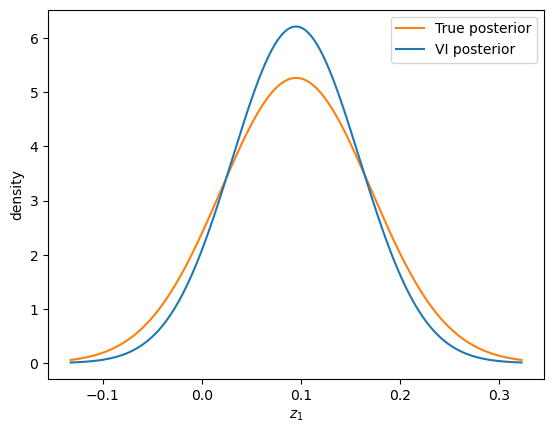

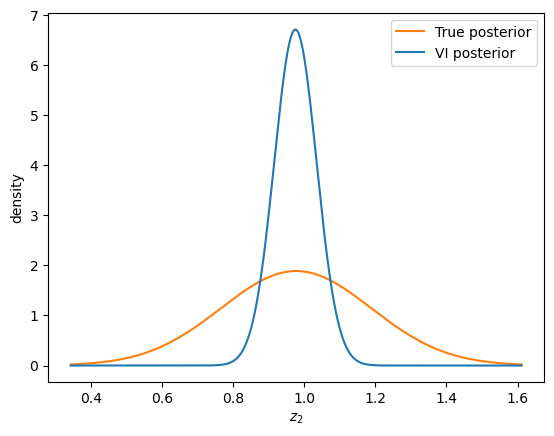

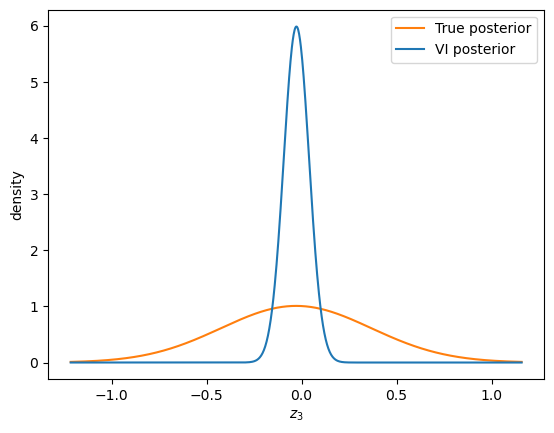

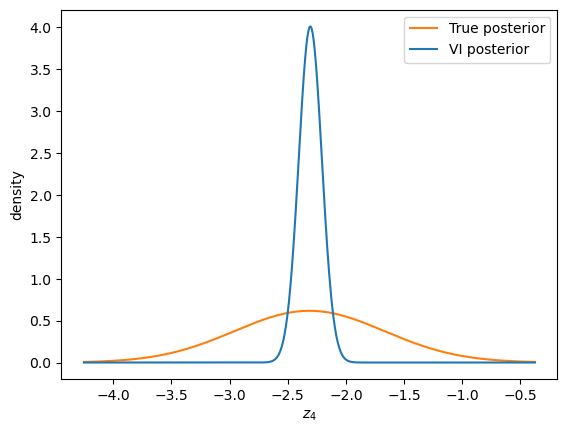

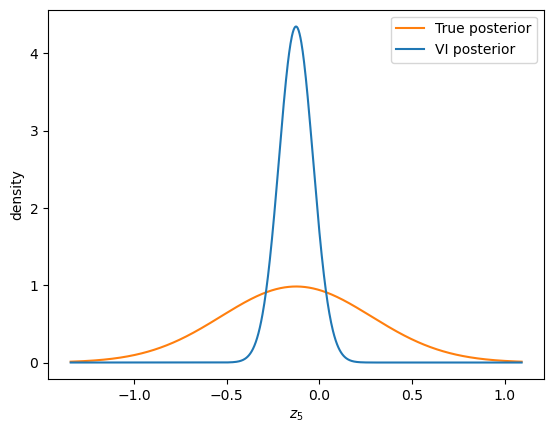

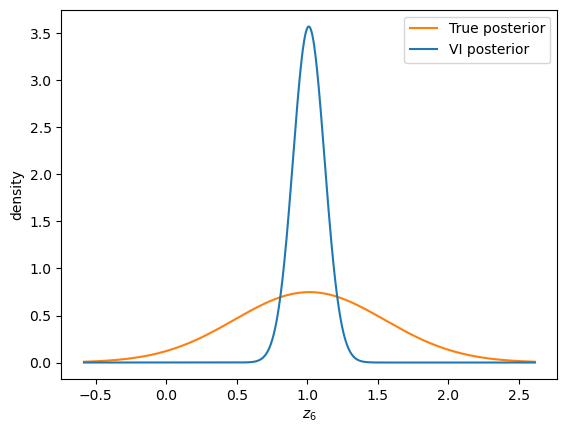

In [11]:
mean_vi, log_s_vi = reshape(lmbda)
stdv_vi = np.exp2(log_s_vi)

for i, (mean, variance) in enumerate(zip(m, np.diag(S))):

    # Generate data points for x-axis
    x_vals = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)

    # Calculate the corresponding probability density function (PDF) values
    pdf_values = norm.pdf(x_vals, mean, np.sqrt(variance))
    plt.plot(x_vals, pdf_values, c='C1', label='True posterior')
    
    # Calculate the corresponding probability density function (PDF) values
    pdf_values = norm.pdf(x_vals, mean_vi[i], stdv_vi[i])
    plt.plot(x_vals, pdf_values, c='C0', label='VI posterior')
    
    # plot NN posterior 
    # plt.hist(np.array(z[:, i]), color='C0', bins=50, density=True, label='VI posterior samples')
    
    plt.xlabel(f"$z_{i+1}$")
    plt.ylabel("density")
    plt.legend()
    plt.show()

In [12]:
# plot posterior predictive 
t_samples = vmap(model, (None, 0))(x_eval, z)
t_hat = np.mean(t_samples, 0)
s_hat = np.std(t_samples, 0)

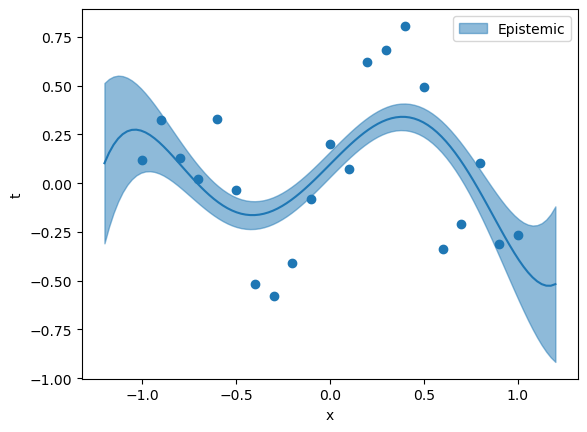

In [13]:
plt.scatter(x, t)
plt.plot(x_eval, t_hat)
plt.fill_between(x_eval, t_hat-s_hat, t_hat+s_hat, alpha=.5, color='C0', label='Epistemic')
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()